# On Home and Real Estate Sales in Ames, Iowa

This survey examines and evaluates potential factors for the improvement of property value by home and real estate owners intending to sell.

### Table of Contents:

- Part I: Introduction
- Part II: Data Cleaning Summary
- Part III: EDA Summary
- Part IV: Predictive Model and Relevant Findings
- Part V: Conclusion

## Part I: Introduction

Home sellers often find themselves overwhelmed by the prospect of property appraisal. When are they moving, and to where? How much is their home worth and how much time is there to realize this potential? And (perhaps most importantly during the final year) what can be done in the time remaining to improve property value and receive the highest possible selling price?

What follows seeks to answer this latter question. While many factors influence the selling price of a home, they are often beyond an owner's immediate control to improve or change. These factors are still quite relevant, as they have a significant role in determining what an owner can expect to make in profit (and thus what an owner can expect to have available for a future home purchase). However, in another sense, more relevant factors consist of things a home owner might alter in what time remains before the sale date to turn the highest profit.

The final linear regression model, described in detail below, exists in such a way as to provide the most accurate price evaluation possible while still remaining germaine to the specific purpose at hand (i.e. to determine potential courses of action for improving final sale price).

##### Initial Datasets Used

- [`train.csv`](datasets/train.csv): Ames, IA Real Estate Training Dataset
- [`test.csv`](datasets/test.csv): Ames, IA Real Estate Testing Dataset

## Part II: Data Cleaning Summary

To the end of maintaining a concise summary notebook, a more extensive treatment of the data cleaning process is kept in the `appendices` folder.

Briefly, the main thrust of the cleaning process consisted of imputing empty cells where necessary to ensure that all columns for both the training and the testing data were full, and serviceable for the exploratory data analysis to come. For the training and testing data respectively, initial summary information can be found in the `cleaning` folder:



- Training data descriptive statistics and summary information
- Testing data descriptive statistics and summary information

As further reference, additional information is provided regarding these datasets in their prepared form:

- Training data descriptive statistics and summary information (final)
- Testing data descriptive statistics and summary information (final)
- Training dataset (post-cleaning)
- Testing dataset (post-cleaning)

This encapsulates the bulk of cleaning done for the project. Some datatype conversion for the test set follows in the EDA/feature engineering appendix to maintain synchronicity with the training set. Where necessary, estimated values are imputed.

## Part III: EDA Summary

Again, as is done for data cleaning, more detailed information regarding exploratory analysis for this project can be found in the `appendices` folder.

Many, many features were generated and tested for relevance during the exploratory process. The purpose was always close at hand, and this required a model that made use of the data available as efficiently as possible. For categorical variables, this generally meant dummification or conversion to a numeric scale.

This last point (numeric scalability) is especially important, because many of the more malleable property traits (i.e. the relative condition of this or that room or amenity) exist in the initial datasets as categorical variables. Indexing these according to integer values allows modeling from which greater inferential insight can be extracted.

## Part IV: Predictive Model and Relevant Findings

Initial imports and file read:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression

In [2]:
train = pd.read_csv('datasets/final_train.csv').drop(columns=['Unnamed: 0'])

The pairplot below demonstrates the relationship found early in the exploratory phase between all things related to property size (i.e. the square footage of various areas) and sales price (first row). Unsurprisingly, in many cases, a strong positive correlation becomes visible. The more home there is to sell, the more a home sells for.

In [3]:
pairplot1 = train[['sale_price', 'lot_area', 'bsmtfin_sf_1', 'bsmtfin_sf_2', 'bsmt_unf_sf', 'total_bsmt_sf', 
                  '1st_flr_sf', '2nd_flr_sf', 'low_qual_fin_sf', 'gr_liv_area', 'mas_vnr_area', 'total_sf']]

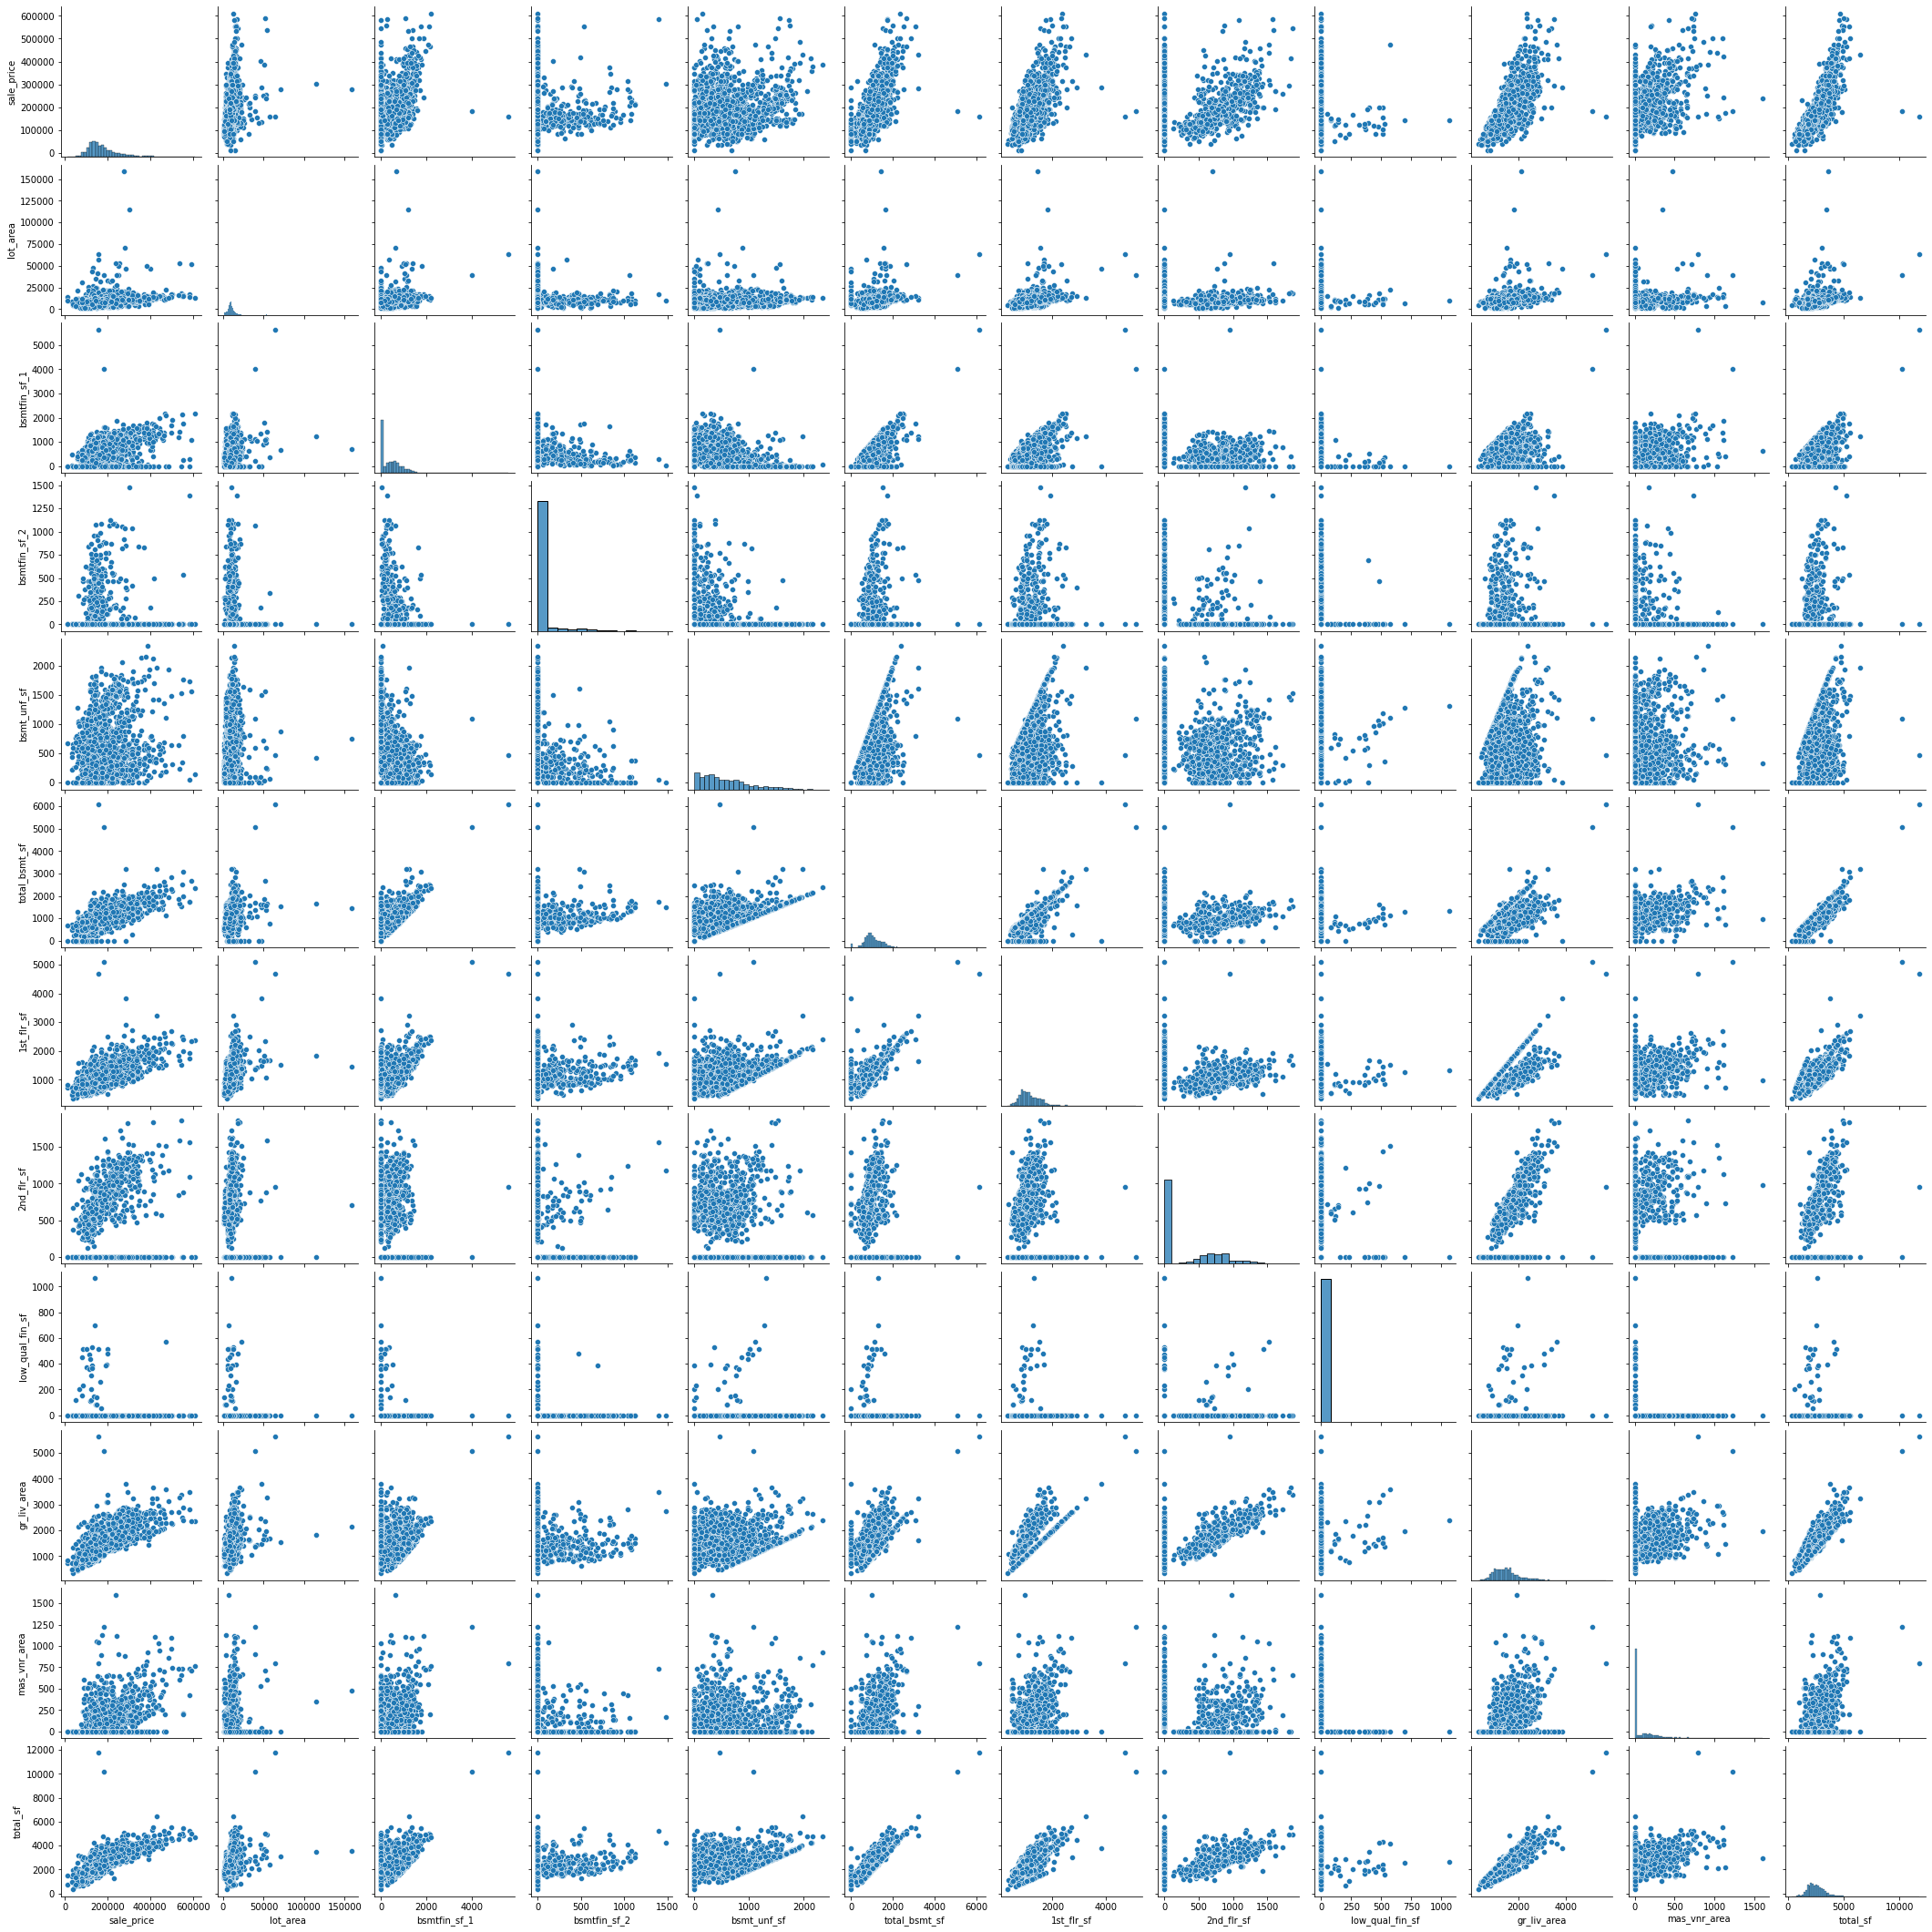

In [4]:
sns.pairplot(pairplot1)
plt.savefig('visualizations/01_area_based_pairplot')
plt.show();

To avoid potential multicollinearity issues, it was necessary during EDA to check for any strong correlations between the respective sizes of different home sections. With the exception of `total_sf`, or total square footage, the values are passably independent.

In [5]:
heatmap1 = train[['sale_price', 'lot_area', 'bsmtfin_sf_1', 'bsmtfin_sf_2', 'bsmt_unf_sf', 'total_bsmt_sf', 
                  '1st_flr_sf', '2nd_flr_sf', 'low_qual_fin_sf', 'gr_liv_area', 'mas_vnr_area', 'total_sf']]

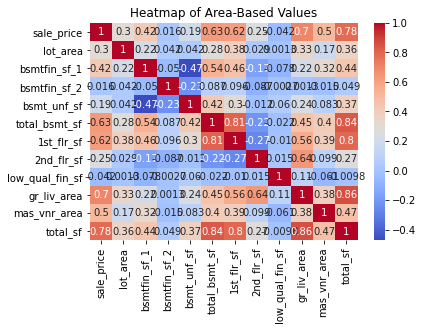

In [6]:
plt.title('Heatmap of Area-Based Values')
sns.heatmap(heatmap1.corr(), annot=True, cmap='coolwarm')
plt.savefig('visualizations/02_area_based_heatmap')
plt.show();

A note on values related to years that a property was built or had work done: 

Because of the way these values appear linear from the distant past up until the turn of the twenty-first century, this allows experimentation with 'smarting up the dummies', or factoring in a progressive correlation coefficient for properties built before 2000, and then applying a dummy coefficient for properties built later. The same could be done for values reflecting the year that a property had additions, was refurbished, etc.

Essentially, this meant creating dummy columns for each category of year (before or including the year 2000 and after it), then creating a column for the product of the year number and the 'before the year 2000' value. The dummy column that populates as `True` for older properies/refurbishments is then dropped.

This allowed experimentation with both a dummy column for newer properties and a more progressive column for older properties, where it is appropriate. Because these traits are mutually exclusive, neither ever trips over the other. A property with a non-zero value for one of the columns necessarily has a zero-value for the other (as with dummies), and the gradational nature of the values for older properties might, depending on the model, allow the variable to hug the line closer.

In [7]:
pairplot2 = train[['sale_price', 'year_built', 'year_remod/add']]

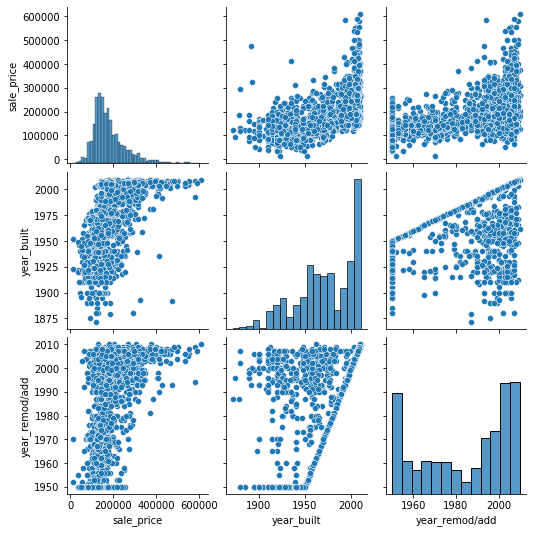

In [8]:
sns.pairplot(pairplot2)
plt.savefig('visualizations/03_age_based_pairplot')
plt.show();

Of course, a property's location affects its perceived value dramatically. Due to the gradual increase of property value with respect to neighborhood, these areas were indexed according to their relative price ranges and dummified for the model.

In [9]:
train.groupby('nbhd_rank_idx')['sale_price'].mean()

nbhd_rank_idx
1    322573.177885
2    231461.178571
3    196574.480565
4    167656.707317
5    138616.479885
6    115511.843636
Name: sale_price, dtype: float64

Because of the focus of this survey on the winnable games of home selling, the exploratory process involved a great deal of experimentation with all things related to construction quality and property condition. Ensuring that the various areas of a home are in good repair is a real concern for home owners intending to sell. Individuals and families often have a limited time frame with which to work, while major construction projects like home additions and remodels are often timely and costly. But if there are significant areas within the home that might be reasonably improved or refurbished to turn a better profit, this is good news indeed.

Much like the neighborhood index, these values were numerically encoded and baked into the model in many permutations. The consistent winners--values that demonstrated predictive power in modeling real estate selling price)--were variables related to fireplace quality/condition and kitchen condition.

Below, homes indexed by the condition of their fireplace (where there is one) are shown alongside their respective mean selling price. Each neighborhood receives treatment, and with only a few exceptions of 'neighboring' fireplace appraisals (i.e. 'good' and 'fair'), possibly due to a dearth of samples, the numbers suggest a strong positive correlation generally.

In [10]:
train.query('nbhd_rank_idx == 1').groupby('fire_code')['sale_price'].mean()

fire_code
0    221377.050000
2    298660.173913
3    262000.000000
4    340455.090909
5    373612.300000
Name: sale_price, dtype: float64

In [11]:
train.query('nbhd_rank_idx == 2').groupby('fire_code')['sale_price'].mean()

fire_code
0    198472.197674
2    228837.523810
3    212375.000000
4    264590.702381
5    310725.000000
Name: sale_price, dtype: float64

In [12]:
train.query('nbhd_rank_idx == 3').groupby('fire_code')['sale_price'].mean()

fire_code
0    175560.014151
1    164000.000000
2    203748.350515
3    187438.076923
4    217949.140845
5    267260.000000
Name: sale_price, dtype: float64

In [13]:
train.query('nbhd_rank_idx == 4').groupby('fire_code')['sale_price'].mean()

fire_code
0    152383.653846
1    164375.000000
2    204426.666667
3    179300.000000
4    214600.000000
5    130500.000000
Name: sale_price, dtype: float64

In [14]:
train.query('nbhd_rank_idx == 5').groupby('fire_code')['sale_price'].mean()

fire_code
0    126554.739130
1    136751.571429
2    156425.567010
3    148523.437500
4    161169.961538
5    166750.000000
Name: sale_price, dtype: float64

In [15]:
train.query('nbhd_rank_idx == 6').groupby('fire_code')['sale_price'].mean()

fire_code
0    106336.194444
1    114975.000000
2    175023.076923
4    140657.048780
5    295000.000000
Name: sale_price, dtype: float64

Similarly, kitchens as well:

In [16]:
train.query('nbhd_rank_idx == 1').groupby('ktch_code')['sale_price'].mean()

ktch_code
2    177666.666667
4    283448.715447
5    386561.329268
Name: sale_price, dtype: float64

In [17]:
train.query('nbhd_rank_idx == 2').groupby('ktch_code')['sale_price'].mean()

ktch_code
2    194262.676471
4    225942.969325
5    311617.370370
Name: sale_price, dtype: float64

In [18]:
train.query('nbhd_rank_idx == 3').groupby('ktch_code')['sale_price'].mean()

ktch_code
2    171560.333333
3    147437.500000
4    205466.221893
5    293052.000000
Name: sale_price, dtype: float64

In [19]:
train.query('nbhd_rank_idx == 4').groupby('ktch_code')['sale_price'].mean()

ktch_code
2    153904.385965
3    242500.000000
4    197200.000000
Name: sale_price, dtype: float64

In [20]:
train.query('nbhd_rank_idx == 5').groupby('ktch_code')['sale_price'].mean()

ktch_code
2    133777.569061
3    101882.692308
4    161503.913043
5    217829.166667
Name: sale_price, dtype: float64

In [21]:
train.query('nbhd_rank_idx == 6').groupby('ktch_code')['sale_price'].mean()

ktch_code
2    110157.200957
3     80096.437500
4    142490.906977
5    190607.142857
Name: sale_price, dtype: float64

The function here runs the fundamental regression process on any set of independent variables against a single dependent variable and generates an output for the user of key metrics related to the resultant model.

These include the r-squared value of the training set, the r-squared value of the test set, the mean of cross-validation scores, and the RMSE.

A graph is also displayed.

In [33]:
def lin_reg(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y)

    lr = LinearRegression()
    
    lr.fit(X_train, y_train)
    r2_train = lr.score(X_train, y_train)
    r2_test = lr.score(X_test, y_test)
    r2_diff = r2_train - r2_test
    cvs = cross_val_score(estimator=lr, X = X_train, y= y_train, cv = 5, n_jobs = -1).mean()
    residuals = y_test - lr.predict(X_test)
    rmse = ((sum(residuals**2)/len(residuals))**0.5)

    print(' R-squared for training data: ', r2_train, '\n',
          'R-squared for testing data: ', r2_test, '\n',
          'R-squared (training) minus R-squared (testing): ', r2_train - r2_test, '\n',
          'Cross-validation score: ', r2_test, '\n',
          'Root mean squared error: ', rmse)
    
    y_preds = lr.predict(X_test)
    resids = y_test - y_preds
    
    plt.scatter(y_preds, resids, s=1)
    plt.axhline(0, color='orange')
    plt.show;


The modeling process began with considerations of property size. Predictive perfection is not the sole focus of this project, but to the degree possible, an accurate estimate of property value is helpful for any home seller.

Ultimately, the model considers square footage for a handful of home areas, and also the number of bathrooms.

In [23]:
X = train[['1st_flr_sf', 'total_bsmt_sf', '2nd_flr_sf', 'total_bth',
            'garage_area', 'overall_qual', 'mas_vnr_area', 'gr_liv_area']]
y = train['sale_price']

 R-squared for training data:  0.8331639674629949 
 R-squared for testing data:  0.6523686709925476 
 R-squared (training) minus R-squared (testing):  0.18079529647044734 
 Cross-validation score:  0.6523686709925476 
 Root mean squared error:  47397.339122617195


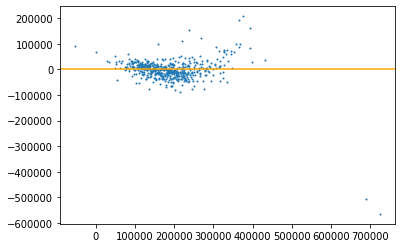

In [24]:
lin_reg(X, y)

Next came neighborhood considerations, and these inproved the model greatly.

In [25]:
X = train[['1st_flr_sf', 'total_bsmt_sf', '2nd_flr_sf', 'total_bth',
           'garage_area', 'overall_qual', 'mas_vnr_area', 'gr_liv_area',
           'nbhd_rank_idx_1', 'nbhd_rank_idx_2', 'nbhd_rank_idx_3', 'nbhd_rank_idx_4', 'nbhd_rank_idx_5', 'nbhd_rank_idx_6']]

 R-squared for training data:  0.8237354099673323 
 R-squared for testing data:  0.8185925059359677 
 R-squared (training) minus R-squared (testing):  0.005142904031364637 
 Cross-validation score:  0.8185925059359677 
 Root mean squared error:  31735.38527133968


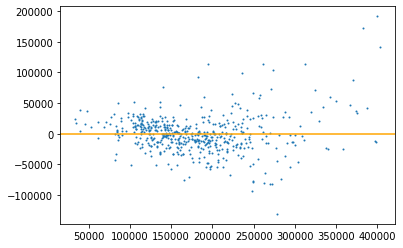

In [26]:
lin_reg(X, y)

An assortment of other considerations were added to the model, including those for overall construction quality, the position of a property in relation to amenities nearby (`pos_a/n`), and whether or not the property is new or has newly remodeled. Sale type is also considered.

In [34]:
X = train[['1st_flr_sf', 'total_bsmt_sf', '2nd_flr_sf', 'total_bth',
           'garage_area', 'overall_qual', 'mas_vnr_area', 'gr_liv_area',
           'nbhd_rank_idx_1', 'nbhd_rank_idx_2', 'nbhd_rank_idx_3', 'nbhd_rank_idx_4', 'nbhd_rank_idx_5', 'nbhd_rank_idx_6',
           'pos_a/n', 'is_new', 'is_new_rem', 'sale_code']]

 R-squared for training data:  0.845986317707665 
 R-squared for testing data:  0.7697767063259959 
 R-squared (training) minus R-squared (testing):  0.07620961138166904 
 Cross-validation score:  0.7697767063259959 
 Root mean squared error:  37968.72695318909


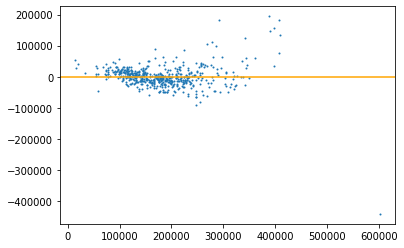

In [35]:
lin_reg(X, y)

The last step, with a reasonably reliable model in hand, was to factor in the variables that are this survey's primary focus, namely the repair in which various areas of any given property are maintained. Many of the variables provided in the initial dataset were tried--pool quality, garage and basement condition, etc.--and as touched on earlier, the kitchen and the fireplace stood out. Note that the kitchen was ultimately dummied according to whether or not it was "excellent" or "not excellent".

Below, the combination of factors considered in this model are presented in their final form:

In [40]:
X = train[['1st_flr_sf', 'total_bsmt_sf', '2nd_flr_sf', 'total_bth',
           'garage_area', 'overall_qual', 'mas_vnr_area', 'gr_liv_area',
           'nbhd_rank_idx_1', 'nbhd_rank_idx_2', 'nbhd_rank_idx_3', 'nbhd_rank_idx_4', 'nbhd_rank_idx_5', 'nbhd_rank_idx_6',
           'pos_a/n', 'ex_kitch', 'is_new', 'is_new_rem', 'log_qual',
           'bsmt_code', 'grg_code', 'sale_code']]

 R-squared for training data:  0.8450453409409121 
 R-squared for testing data:  0.8538638607921172 
 R-squared (training) minus R-squared (testing):  -0.008818519851205076 
 Cross-validation score:  0.8538638607921172 
 Root mean squared error:  27395.366204848975


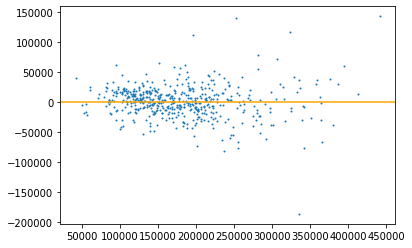

In [42]:
lin_reg(X, y)

But for a handful of outliers, the residuals occupy a relatively consistent orbit across the given range of sales prices, and our linear regression efforts have served their purpose. The following heatmap reinforces the model's findings. For home sellers, the kitchen and the fireplace are where it's at.

In [31]:
heatmap2 = train[['sale_price', 'overall_qual', 'overall_cond', 'sale_code', 'zone_code', 'fire_code', 
                  'grg_code', 'pool_code', 'ktch_code', 'bsmt_code']]

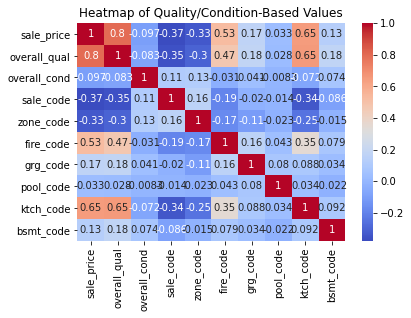

In [32]:
plt.title('Heatmap of Quality/Condition-Based Values')
sns.heatmap(heatmap2.corr(), annot=True, cmap='coolwarm');
plt.savefig('visualizations/04_condition_based_heatmap')
plt.show();

## Part V: Conclusion

Further study might allow for the development of an even more accurate model, in which case, the relative significance of each variable could at least potentially change.

In the meantime, to reiterate, home owners considering or intent on selling would do well to focus first on improving kitchen areas and then on improving fireplaces to maximize profit when time is limited.